Доржиев А.С. АБД19-1М

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers 
from keras import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import mnist, cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD 
from keras.utils import np_utils
from keras.layers import SimpleRNN, Dense, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error 


In [ ]:
import math 
from math import sqrt
from matplotlib import pyplot
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from keras.layers.recurrent import LSTM

# Задача 1. Потребление электроэнергии
определите наиболее эффективную модель для прогноза потребления электроэнергии (графики!!)

In [ ]:
PATH = "/content/drive/My Drive/Нейронные сети 1_Модуль_2020/"

In [ ]:
dataset = pd.read_csv(PATH+'household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])

In [ ]:
dataset.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
dataset.replace('?', np.nan, inplace=True)

In [ ]:
dataset = dataset.astype('float32')

In [ ]:
# Препроцессинг 
# Пропущенные значения заменим на значения днем ранее
def fill_missing(values): 
  one_day = 60*24
  for row in range(values.shape[0]):
    for col in range(values.shape[1]):
      if np.isnan(values[row,col]):
        values[row,col] = values[row - one_day,col]

In [ ]:
fill_missing(dataset.values)


* В данной задаче предполагается оперирование с ежедневными значениями, а не поминутными (не обязательно)
* Pd.resample() - применение этой функции с аргументом «D» позволяет группировать по дням загруженные данные, проиндексированные по дате и времени.

In [ ]:
daily_groups = dataset.resample('D') 
daily_data = daily_groups.sum()

In [ ]:
daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [ ]:
# Моделирование дополнительных признаков
#dataset['Sub_metering_remainder'] = (dataset['Global_active_power'] * 1000 / 60) - (dataset['Sub_metering_1'] + dataset['Sub_metering_2'] + dataset['Sub_metering_3'])

In [ ]:
# сохраним
#dataset.to_csv(PATH+'household_power_consumption2.csv')

In [ ]:
# Моделирование дополнительных признаков для ежедневных данных 
daily_data['Sub_metering_remainder'] = (daily_data['Global_active_power'] * 1000 / 60) - (daily_data['Sub_metering_1'] + daily_data['Sub_metering_2'] + daily_data['Sub_metering_3'])

In [ ]:
daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_remainder
datetime,,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0,14680.933594
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0,36946.667969
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0,19028.433594
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0,13131.900391
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0,20384.800781


In [ ]:
daily_data.shape

(1442, 8)

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

In [ ]:
def split_dataset(data):
  train, test = data[1:-328], data[-328:-6]
  train = np.array(np.split(train, len(train)/7)) 
  test = np.array(np.split(test, len(test)/7)) 
  return train, test

In [ ]:
# evaluate a single model
def evaluate_model(train, test, n_input):
	# fit model
	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [ ]:
# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

In [ ]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [ ]:
daily_data.shape

(1442, 8)

In [ ]:
dataset.shape

(2075259, 7)

In [ ]:
# Выберем 
#train, test = split_dataset(dataset.values) # не обучилась
train, test = split_dataset(daily_data.values) 

#data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

In [ ]:
# train the model
def build_model(train, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 1, 50, 16 #0, 70, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# define model
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [ ]:
# make a forecast
def forecast(model, history, n_input):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, len(input_x), 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

### LSTM для интервального прогнозирования временных рядов

In [ ]:
n_input = 7 
score, scores = evaluate_model(train, test, n_input)

Epoch 1/50
69/69 [==============================] - 1s 16ms/step - loss: 826449.6875
Epoch 2/50
69/69 [==============================] - 1s 12ms/step - loss: 273448.0312
Epoch 3/50
69/69 [==============================] - 1s 13ms/step - loss: 266874.9375
Epoch 4/50
69/69 [==============================] - 1s 12ms/step - loss: 264119.9062
Epoch 5/50
69/69 [==============================] - 1s 14ms/step - loss: 3133742.7500
Epoch 6/50
69/69 [==============================] - 1s 12ms/step - loss: 295849.0625
Epoch 7/50
69/69 [==============================] - 1s 12ms/step - loss: 272250.9688
Epoch 8/50
69/69 [==============================] - 1s 12ms/step - loss: 266659.5000
Epoch 9/50
69/69 [==============================] - 1s 12ms/step - loss: 263948.4375
Epoch 10/50
69/69 [==============================] - 1s 12ms/step - loss: 267432.5000
Epoch 11/50
69/69 [==============================] - 1s 12ms/step - loss: 261756.5625
Epoch 12/50
69/69 [==============================] - 1s 14ms/s

In [ ]:
summarize_scores('lstm', score, scores)

lstm: [394.993] 392.7, 421.1, 372.3, 377.1, 403.2, 320.6, 463.2


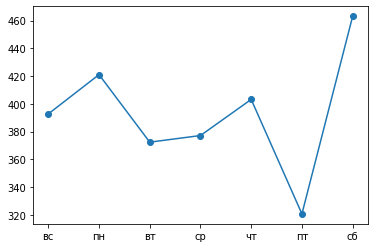

In [ ]:
# plot scores
days = ['вс', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

Вторники и пятницы являются более лёгкими для прогнозирования днями, чем остальные, а суббота является самым трудным днём для прогнозирования.

Увеличим количество предыдущих дней, используемых в качестве входных данных, с 7 до 14 дней

In [ ]:
train, test = split_dataset(daily_data.values) 
n_input = 14
score, scores = evaluate_model(train, test, n_input) 

Epoch 1/50
69/69 [==============================] - 1s 22ms/step - loss: 702440.0000
Epoch 2/50
69/69 [==============================] - 2s 23ms/step - loss: 266412.5625
Epoch 3/50
69/69 [==============================] - 2s 23ms/step - loss: 268139.5938
Epoch 4/50
69/69 [==============================] - 2s 23ms/step - loss: 262616.0000
Epoch 5/50
69/69 [==============================] - 2s 23ms/step - loss: 258851.1562
Epoch 6/50
69/69 [==============================] - 2s 23ms/step - loss: 259067.7188
Epoch 7/50
69/69 [==============================] - 2s 25ms/step - loss: 251840.7969
Epoch 8/50
69/69 [==============================] - 1s 22ms/step - loss: 251094.1562
Epoch 9/50
69/69 [==============================] - 2s 22ms/step - loss: 260107.1875
Epoch 10/50
69/69 [==============================] - 1s 20ms/step - loss: 251741.8594
Epoch 11/50
69/69 [==============================] - 1s 22ms/step - loss: 250209.2656
Epoch 12/50
69/69 [==============================] - 1s 22ms/st

In [ ]:
summarize_scores('lstm', score, scores)

lstm: [380.111] 396.7, 395.9, 367.6, 385.0, 373.9, 299.6, 429.3


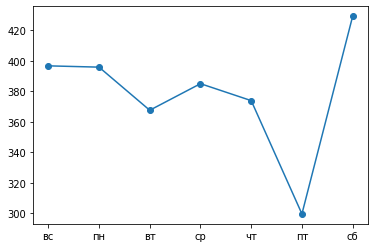

In [ ]:
# plot scores
days = ['вс', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

### «кодировщик-декодировщик» на основе одномерных входных данных

In [ ]:
def build_model(train, n_input):
	train_x, train_y = to_supervised(train, n_input)
	verbose, epochs, batch_size = 1, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	model = Sequential()
	model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu'))) 
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [ ]:
train, test = split_dataset(daily_data.values) 
n_input = 14
score, scores = evaluate_model(train, test, n_input) 

Epoch 1/50
69/69 [==============================] - 2s 32ms/step - loss: 827550.7500
Epoch 2/50
69/69 [==============================] - 2s 32ms/step - loss: 385926.2500
Epoch 3/50
69/69 [==============================] - 3s 39ms/step - loss: 348079.6875
Epoch 4/50
69/69 [==============================] - 2s 32ms/step - loss: 344814.9062
Epoch 5/50
69/69 [==============================] - 2s 32ms/step - loss: 306563.1562
Epoch 6/50
69/69 [==============================] - 2s 33ms/step - loss: 301727.0312
Epoch 7/50
69/69 [==============================] - 3s 37ms/step - loss: 266791.0625
Epoch 8/50
69/69 [==============================] - 3s 38ms/step - loss: 278475.9375
Epoch 9/50
69/69 [==============================] - 2s 31ms/step - loss: 265442.8438
Epoch 10/50
69/69 [==============================] - 2s 35ms/step - loss: 254102.3750
Epoch 11/50
69/69 [==============================] - 2s 31ms/step - loss: 257773.4375
Epoch 12/50
69/69 [==============================] - 2s 35ms/st

In [ ]:
summarize_scores('lstm', score, scores)

lstm: [395.611] 401.7, 411.3, 377.7, 385.5, 418.1, 347.2, 422.3


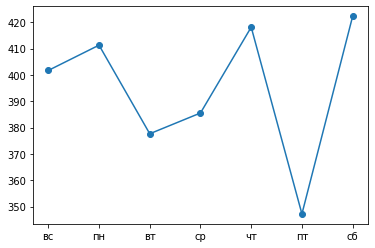

In [ ]:
# plot scores
days = ['вс', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

###«кодировщик-декодировщик» на основе многомерных входных данных

In [ ]:
def to_supervised(train, n_input, n_out=7):
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	for _ in range(len(data)):
		in_end = in_start + n_input
		out_end = in_end + n_out
		if out_end <= len(data):
			X.append(data[in_start:in_end, :])
			y.append(data[in_end:out_end, 0])
		in_start += 1
	return np.array(X), np.array(y) 

In [ ]:
def forecast(model, history, n_input):
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	input_x = data[-n_input:, :]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	yhat = model.predict(input_x, verbose=0)
	yhat = yhat[0]
	return yhat

In [ ]:
n_input = 14
score, scores = evaluate_model(train, test, n_input)

Epoch 1/50
69/69 [==============================] - 3s 38ms/step - loss: 236636432.0000
Epoch 2/50
69/69 [==============================] - 2s 32ms/step - loss: 54187132.0000
Epoch 3/50
69/69 [==============================] - 2s 34ms/step - loss: 18306378.0000
Epoch 4/50
69/69 [==============================] - 2s 31ms/step - loss: 5714230.0000
Epoch 5/50
69/69 [==============================] - 2s 35ms/step - loss: 471530.4375
Epoch 6/50
69/69 [==============================] - 2s 34ms/step - loss: 340869.6250
Epoch 7/50
69/69 [==============================] - 2s 31ms/step - loss: 352029.6562
Epoch 8/50
69/69 [==============================] - 2s 34ms/step - loss: 337463.5312
Epoch 9/50
69/69 [==============================] - 2s 32ms/step - loss: 334882.4375
Epoch 10/50
69/69 [==============================] - 2s 31ms/step - loss: 310906.0625
Epoch 11/50
69/69 [==============================] - 2s 32ms/step - loss: 340327.5000
Epoch 12/50
69/69 [==============================] - 2s

In [ ]:
summarize_scores('lstm', score, scores)

lstm: [398.502] 440.9, 406.0, 364.1, 388.2, 372.0, 310.1, 484.4


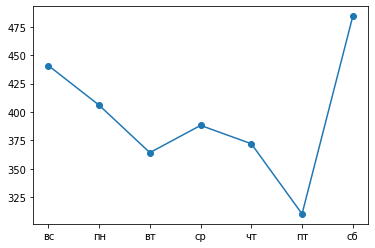

In [ ]:
# plot scores
days = ['вс', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

тот же вывод, что и выше

### Кодировщик Conv

In [ ]:
def build_model(train, n_input):
	train_x, train_y = to_supervised(train, n_input)
	verbose, epochs, batch_size = 1, 50, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
 
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

In [ ]:
n_input = 14
score, scores = evaluate_model(train, test, n_input)

Epoch 1/50
69/69 [==============================] - 1s 14ms/step - loss: 31830458.0000
Epoch 2/50
69/69 [==============================] - 1s 13ms/step - loss: 380280.4688
Epoch 3/50
69/69 [==============================] - 1s 13ms/step - loss: 325697.1250
Epoch 4/50
69/69 [==============================] - 1s 13ms/step - loss: 303733.2500
Epoch 5/50
69/69 [==============================] - 1s 13ms/step - loss: 336130.0000
Epoch 6/50
69/69 [==============================] - 1s 14ms/step - loss: 412420.6562
Epoch 7/50
69/69 [==============================] - 1s 13ms/step - loss: 327141.5938
Epoch 8/50
69/69 [==============================] - 1s 14ms/step - loss: 327254.6562
Epoch 9/50
69/69 [==============================] - 1s 13ms/step - loss: 334299.9375
Epoch 10/50
69/69 [==============================] - 1s 14ms/step - loss: 386674.7812
Epoch 11/50
69/69 [==============================] - 1s 14ms/step - loss: 408424.6250
Epoch 12/50
69/69 [==============================] - 1s 14ms/

In [ ]:
summarize_scores('lstm', score, scores)

lstm: [377.288] 397.3, 365.4, 332.1, 395.1, 353.2, 315.5, 462.9


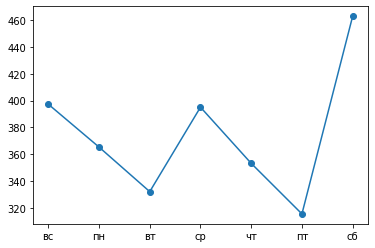

In [ ]:
# plot scores
days = ['вс', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()

вторник и пятница опять же лучше всего прогнозируются

### ConvLSTM для кодировщика

In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data):
	# split into standard weeks
	train, test = data[1:-328], data[-328:-6]
	# restructure into windows of weekly data
	train = array(split(train, len(train)/7))
	test = array(split(test, len(test)/7))
	return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
	# prepare data
	train_x, train_y = to_supervised(train, n_input)
	# define parameters
	verbose, epochs, batch_size = 0, 20, 16
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape into subsequences [samples, time steps, rows, cols, channels]
	train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
	# reshape output into [samples, timesteps, features]
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
	# define model
	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(200, activation='relu', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='relu')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	# fit network
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	return model

# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
	# flatten data
	data = array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [samples, time steps, rows, cols, channels]
	input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores

In [ ]:
# split into train and test
train, test = split_dataset(daily_data.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)

In [ ]:
# summarize scores
summarize_scores('lstm', score, scores)


lstm: [402.461] 416.1, 421.7, 381.3, 394.5, 402.8, 367.3, 429.8


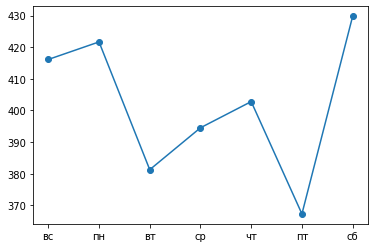

In [ ]:
# plot scores
days = ['вс', 'пн', 'вт', 'ср', 'чт', 'пт', 'сб']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()


# Задача 2
Определите стоимость акций любой компании по историческим данным используя разные нейросетевые модели

путем анализа скользящего периода

https://github.com/ranaroussi/yfinance

https://medium.com/@jouneidraza522/yahoo-finance-api-to-get-stocks-tickers-data-in-python-c49820249a18

In [ ]:
 pip install yahoo-finance

     |████████████████████████████████| 133kB 10.0MB/s 
  Created wheel for yahoo-finance: filename=yahoo_finance-1.4.0-cp36-none-any.whl size=7234 sha256=702136d2b26e9490d2a77e179de7ee36eedb9a28cf0a6e03202e206049c27462
  Stored in directory: /root/.cache/pip/wheels/58/77/5b/66026e0fa7af2ee5926a516a70d3df95e17f952c570bc5aee6
Successfully built yahoo-finance


In [ ]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=32a268deb9c9dca4c2d7a58e2f319100e0917c308391b5d7e6eee4b18662c943
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [ ]:
from pandas_datareader import data as pdr

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
# Данные для обучения - акции компании NIKE
df = pdr.get_data_yahoo('NKE', start="2015-07-10", end="2020-07-09") 

In [ ]:
df = df.reset_index()

In [ ]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-07-10,55.400002,54.500000,55.264999,55.259998,5159200.0,51.677193
1,2015-07-13,56.275002,55.400002,55.619999,56.205002,5047600.0,52.560928
2,2015-07-14,56.529999,55.959999,56.419998,56.169998,5561400.0,52.528191
3,2015-07-15,56.195000,55.845001,56.000000,55.950001,5016400.0,52.322456
4,2015-07-16,56.450001,55.924999,56.380001,56.169998,4334600.0,52.528191


In [ ]:
df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1254,2020-07-02,99.660004,98.019997,98.779999,98.430000,5354900.0,98.212433
1255,2020-07-06,100.029999,99.040001,99.620003,99.949997,4995000.0,99.729073
1256,2020-07-07,99.550003,96.919998,99.220001,97.070000,6352900.0,96.855438
1257,2020-07-08,98.980003,96.959999,97.500000,98.839996,5634600.0,98.621521
1258,2020-07-09,98.910004,96.370003,98.550003,96.989998,6282300.0,96.775612


In [ ]:
#df2=pd.read_csv("TSLA.csv")
#print('Number of rows and columns:', df2.shape)
#df2.head(5)
# Number of rows and columns: (1259, 7)

In [ ]:
print('Number of rows and columns:', df.shape)

Number of rows and columns: (1259, 7)


In [ ]:
# Таргет: “Close” 
training_set = df.iloc[:800, 1:2].values
test_set = df.iloc[800:, 1:2].values

In [ ]:
#Let’s build the input features with time lag of 1 day (lag 1):

# Нормализация
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# We have now reshaped the data into the following format (#values, #time-steps, #1 dimensional output).
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [ ]:
X_train.shape

(740, 60, 1)

In [ ]:
# Архитектура сети: LSTM
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 0s 16ms/step - loss: 0.0299
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0083
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0068
Epoch 4/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0065
Epoch 5/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0064
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0056
Epoch 7/100
24/24 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0055
Epoch 9/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0054
Epoch 10/100
24/24 [==============================] - 0s 15ms/step - loss: 0.0048
Epoch 11/100
24/24 [==============================] - 0s 14ms/step - loss: 0.0055
Epoch 12/100
24/24 [==============================] - 0s 13ms/step - loss: 0.0051
Epoch 13/100
24/24 [=====

In [ ]:
df.shape

(1259, 7)

In [ ]:
dataset_train.shape

(800, 1)

In [ ]:
dataset_test.shape

(459, 1)

In [ ]:
dataset_train.head()

,High
0,55.400002
1,56.275002
2,56.529999
3,56.195000
4,56.450001


In [ ]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-07-10,55.400002,54.500000,55.264999,55.259998,5159200.0,51.677193
1,2015-07-13,56.275002,55.400002,55.619999,56.205002,5047600.0,52.560928
2,2015-07-14,56.529999,55.959999,56.419998,56.169998,5561400.0,52.528191
3,2015-07-15,56.195000,55.845001,56.000000,55.950001,5016400.0,52.322456
4,2015-07-16,56.450001,55.924999,56.380001,56.169998,4334600.0,52.528191


In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:800, 1:2]
dataset_test = df.iloc[800:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [ ]:
# Make Predictions using the test set
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
predicted_stock_price.shape

(459, 1)

In [ ]:
df.loc[800:,'Date'].shape

(459,)

In [ ]:
dataset_test.values.shape

(459, 1)

In [ ]:
import matplotlib.dates as mdates

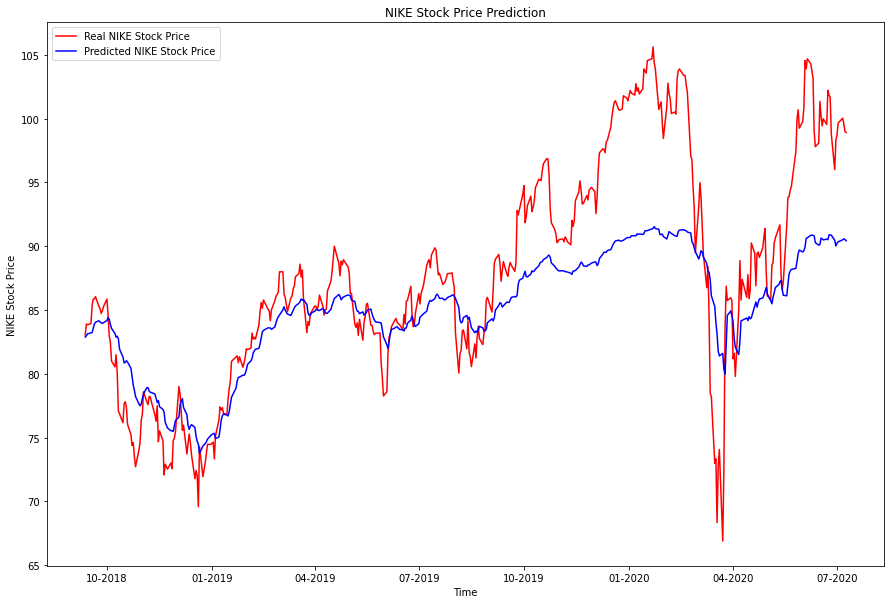

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.plot(df.loc[800:, 'Date'], dataset_test.values, color = 'red', label = 'Real NIKE Stock Price')
ax.plot(df.loc[800:, 'Date'], predicted_stock_price, color = 'blue', label = 'Predicted NIKE Stock Price')

plt.title('NIKE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NIKE Stock Price')
plt.legend()
plt.show()

# Иная архитектура 

In [ ]:
# Архитектура сети: SimpleRNN
model = Sequential()
model.add(SimpleRNN(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 3s 145ms/step - loss: 0.4848
Epoch 2/100
24/24 [==============================] - 3s 137ms/step - loss: 0.3796
Epoch 3/100
24/24 [==============================] - 4s 154ms/step - loss: 0.2806
Epoch 4/100
24/24 [==============================] - 3s 141ms/step - loss: 0.2403
Epoch 5/100
24/24 [==============================] - 4s 158ms/step - loss: 0.1871
Epoch 6/100
24/24 [==============================] - 3s 143ms/step - loss: 0.1562
Epoch 7/100
24/24 [==============================] - 4s 148ms/step - loss: 0.1294
Epoch 8/100
24/24 [==============================] - 4s 161ms/step - loss: 0.1136
Epoch 9/100
24/24 [==============================] - 4s 158ms/step - loss: 0.0892
Epoch 10/100
24/24 [==============================] - 4s 159ms/step - loss: 0.1026
Epoch 11/100
24/24 [==============================] - 4s 154ms/step - loss: 0.0991
Epoch 12/100
24/24 [==============================] - 4s 160ms/step - loss: 0.0809
Epoch 13/100


In [ ]:
# Прогнозы
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

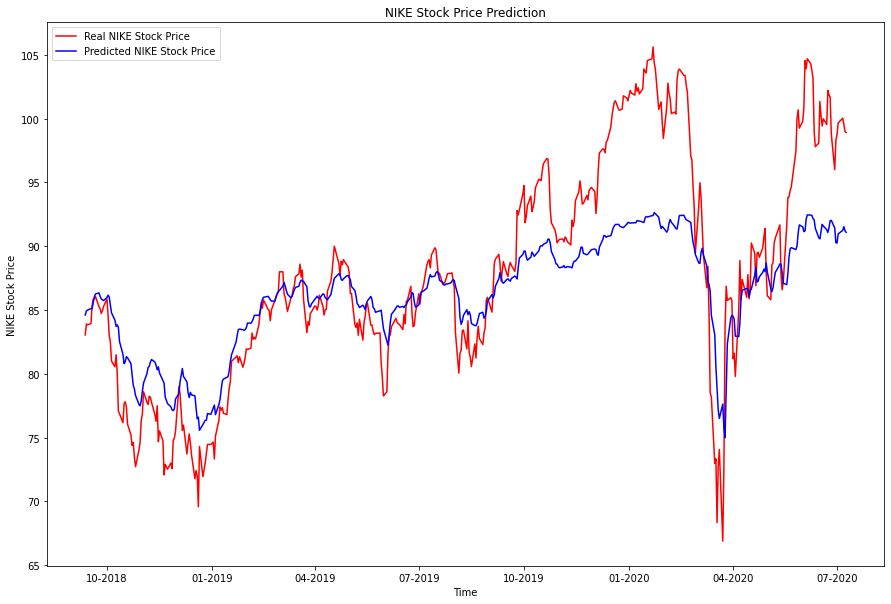

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.plot(df.loc[800:, 'Date'], dataset_test.values, color = 'red', label = 'Real NIKE Stock Price')
ax.plot(df.loc[800:, 'Date'], predicted_stock_price, color = 'blue', label = 'Predicted NIKE Stock Price')

plt.title('NIKE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NIKE Stock Price')
plt.legend()
plt.show()